In [1]:
%env MKL_NUM_THREADS=16
%env OMP_NUM_THREADS=16

env: MKL_NUM_THREADS=16
env: OMP_NUM_THREADS=16


In [2]:
import numpy as np
import pandas as pd
from ipypb import track

from polara.evaluation import evaluation_engine as ee
from polara.evaluation.pipelines import (find_optimal_config,
                                         set_config)

from hybrids import ScaledHybridSVD, ScaledHybridSVDColdStart
from data_preprocessing import (get_amazon_data,
                                get_similarity_data,
                                prepare_data_model,
                                prepare_cold_start_data_model)
from utils import (report_results, save_results,
                   apply_config, read_config, print_data_stats,
                   save_training_time, save_cv_training_time)
%matplotlib inline

In [3]:
from polara.recommender import defaults
defaults.memory_hard_limit = 15 # allowed memory usage during recommendations generation

In [4]:
seed = 42

In [5]:
experiment_name = 'scaledhybridsvd'

# Experiment setup

In [6]:
data_labels = ['AMZe', 'AMZvg']

In [7]:
ranks_grid = [1, 5, 10, 15, 20, 30, 50, 60, 75, 100, 125, 150, 200, 250, 300,
              350, 400, 500, 750, 1000, 1250, 1500, 1750, 2000, 2500, 3000]
svd_ranks = {'AMZe': ranks_grid,
             'AMZvg': [r for r in ranks_grid if r <= 500]
            }

hybridsvd_weights = [0.1, 0.3, 0.5, 0.7, 0.9]

In [8]:
topk_values = [1, 3, 10, 20, 30]

In [9]:
target_metric = 'mrr'

In [10]:
data_dict = dict.fromkeys(data_labels)
meta_dict = dict.fromkeys(data_labels)
similarities = dict.fromkeys(data_labels)
sim_indices = dict.fromkeys(data_labels)
feature_idx = dict.fromkeys(data_labels)

In [11]:
all_data = [data_dict, similarities, sim_indices, meta_dict]

## Amazon Electronics

In [12]:
lbl = 'AMZe'

In [13]:
data_dict[lbl], meta_dict[lbl] = get_amazon_data('../datasets/amazon/ratings_Electronics.csv',
                                                 meta_path='../datasets/amazon/meta/meta_Electronics.json.gz',
                                                 implicit=True,
                                                 pcore=5,
                                                 filter_no_meta=True,
                                                 flat_categories=True) # take only bottom level categories

In [14]:
similarities[lbl], sim_indices[lbl], feature_idx[lbl] = get_similarity_data(meta_dict[lbl])

In [15]:
(meta_dict[lbl].applymap(len).sum(axis=1)==0).mean()

0.0

## Amazon Video Games

In [16]:
lbl = 'AMZvg'

In [17]:
data_dict[lbl], meta_dict[lbl] = get_amazon_data('../datasets/amazon/ratings_Video_Games.csv',
                                                 meta_path='../datasets/amazon/meta/meta_Video_Games.json.gz',
                                                 implicit=True,
                                                 pcore=5,
                                                 filter_data={'categories': ['Games']}, # filter uniformative category
                                                 filter_no_meta=True,
                                                 flat_categories=True) # take only bottom level categories

In [18]:
similarities[lbl], sim_indices[lbl], feature_idx[lbl] = get_similarity_data(meta_dict[lbl])

In [19]:
(meta_dict[lbl].applymap(len).sum(axis=1)==0).mean()

0.0

## Data stats

In [20]:
print_data_stats(data_labels, all_data)

AMZe
{'userid': 124895, 'asin': 44843}
density 0.019153791836615672
similarity matrix density 1.1054998336712965
AMZvg
{'userid': 14251, 'asin': 6858}
density 0.13281340440589384
similarity matrix density 9.081814734274188


# Standard experiment

In [22]:
scaling_params = {lbl: read_config('scaledsvd', lbl)['PureSVDs']['col_scaling'] for lbl in data_labels}

In [26]:
def prepare_recommender_models(data_label, data_models, config):
    data_model = data_models[data_label]
    svd = ScaledHybridSVD(data_model)
    svd.col_scaling = scaling_params[data_label]
    models = [svd]
    apply_config(models, config, data_label)
    return models


def fine_tune_hybridsvd(model, ranks, weights, label, record_time=False):
    model.col_scaling = scaling_params[label]
    param_grid = [(w, r) for w in weights for r in reversed(list(sorted(ranks)))]
    param_names = ('features_weight', 'rank')
    best_svd_config, svd_scores = find_optimal_config(model, param_grid, param_names,
                                                      target_metric,
                                                      return_scores=True,
                                                      force_build=False,
                                                      iterator=lambda x: track(x, label=label))
    model_config = {model.method: dict(zip(param_names, best_svd_config))}
    model_scores = {model.method: svd_scores}
    try:
        if record_time:
            max_rank = max(ranks)
            save_training_time(f'{experiment_name}_rank_{max_rank}', model, svd_scores.xs(max_rank, level='rank').index, label)
    finally:
        return model_config, model_scores

## tuning

In [27]:
config = {}
scores = {}
data_models = {}

In [28]:
for label in track(data_labels):
    data_models[label] = prepare_data_model(label, *all_data, seed)
    config[label], scores[label] = fine_tune_hybridsvd(ScaledHybridSVD(data_models[label]),
                                                       svd_ranks[label],
                                                       hybridsvd_weights,
                                                       label, record_time=True)

 [████████████████████████████████████████████████████████████] 2/2 [12:21:47<07:23, 22253.36s/it]

           AMZe [█████████████████████████████████████████████] 130/130 [12:14:11<00:12, 338.85s/it]

          AMZvg [█████████████████████████████████████████████] 90/90 [07:21<00:01, 4.90s/it]

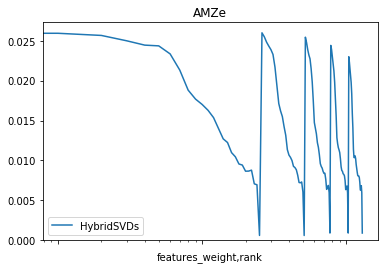

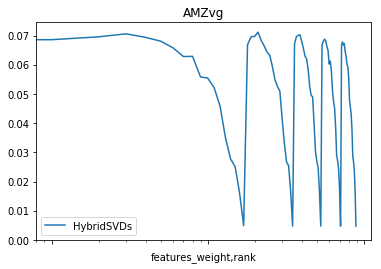

In [29]:
report_results('rank', scores);

In [30]:
config

{'AMZe': {'HybridSVDs': {'features_weight': 0.1, 'rank': 3000}},
 'AMZvg': {'HybridSVDs': {'features_weight': 0.3, 'rank': 300}}}

### saving data

In [31]:
save_results(experiment_name, config=config, tuning=scores)

## cross-validation

In [32]:
result = {}
for label in track(data_labels):
    models = prepare_recommender_models(label, data_models, config)
    result[label] = ee.run_cv_experiment(models,
                                         fold_experiment=ee.topk_test,
                                         topk_list=topk_values,
                                         ignore_feedback=True,
                                         iterator=lambda x: track(x, label=label))
    save_cv_training_time(experiment_name, models, label)

 [████████████████████████████████████████████████████████████] 2/2 [10:54:05<03:34, 19622.52s/it]

           AMZe [█████████████████████████████████████████████] 5/5 [10:50:31<02:01:51, 7806.18s/it]

          AMZvg [█████████████████████████████████████████████] 5/5 [03:34<00:44, 42.81s/it]

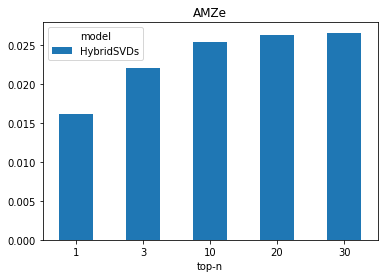

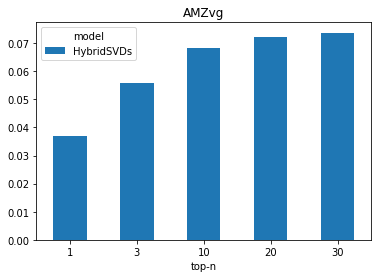

In [33]:
report_results('topn', result, target_metric);

### saving data

In [34]:
save_results(experiment_name, cv=result)

# Cold start

In [35]:
scaling_params = {lbl: read_config('scaledsvd_coldstart', lbl)['PureSVDs(cs)']['col_scaling'] for lbl in data_labels}

In [40]:
def prepare_cold_start_recommender_models(data_label, data_models, config):
    data_model = data_models[data_label]
    svd = ScaledHybridSVDColdStart(data_model, item_features=meta_dict[data_label])
    svd.col_scaling = scaling_params[data_label]
    models = [svd]
    for model in models:
        model.verbose = False
        model_config = config[data_label].get(model.method, None)
        if model_config:
            set_config(model, *list(zip(*model_config.items())))
    return models

## tuning

In [41]:
config_cold = {}
scores_cold = {}
data_models_cold = {}

In [42]:
for label in track(data_labels):
    data_models_cold[label] = prepare_cold_start_data_model(label, *all_data, seed)
    model = ScaledHybridSVDColdStart(data_models_cold[label],
                                     item_features=meta_dict[label])
    model.use_raw_features = True
    config_cold[label], scores_cold[label] = fine_tune_hybridsvd(model,
                                                                 svd_ranks[label],
                                                                 hybridsvd_weights,
                                                                 label)
    del model

 [████████████████████████████████████████████████████████████] 2/2 [11:00:56<05:09, 19828.00s/it]

           AMZe [█████████████████████████████████████████████] 130/130 [10:55:42<00:10, 302.63s/it]

          AMZvg [█████████████████████████████████████████████] 90/90 [05:08<00:00, 3.43s/it]

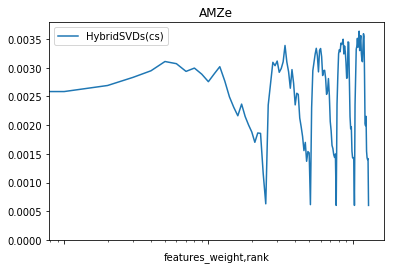

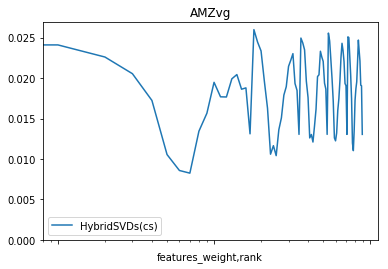

In [43]:
report_results('rank', scores_cold);

In [44]:
config_cold

{'AMZe': {'HybridSVDs(cs)': {'features_weight': 0.9, 'rank': 750}},
 'AMZvg': {'HybridSVDs(cs)': {'features_weight': 0.3, 'rank': 500}}}

### saving data

In [45]:
save_results(experiment_name+'_coldstart', config=config_cold, tuning=scores_cold)

## cross validation

In [46]:
result_cold = {}
for label in track(data_labels):
    models_cold = prepare_cold_start_recommender_models(label, data_models_cold, config_cold)
    result_cold[label] = ee.run_cv_experiment(models_cold,
                                              fold_experiment=ee.topk_test,
                                              topk_list=topk_values,
                                              ignore_feedback=True,
                                              iterator=lambda x: track(x, label=f'{label} folds'))

 [████████████████████████████████████████████████████████████] 2/2 [01:33:58<06:41, 2818.88s/it]

     AMZe folds [█████████████████████████████████████████████] 5/5 [01:27:17<20:27, 1047.38s/it]

    AMZvg folds [█████████████████████████████████████████████] 5/5 [06:41<01:17, 80.16s/it]

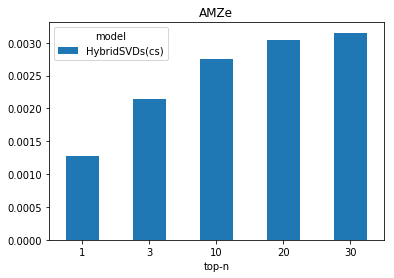

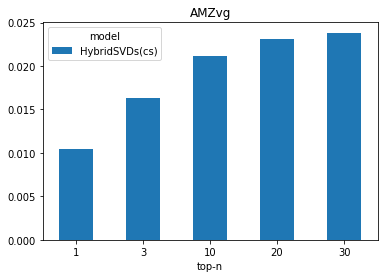

In [47]:
report_results('topn', result_cold, target_metric);

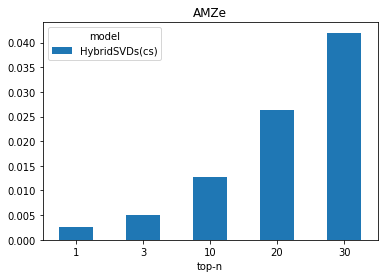

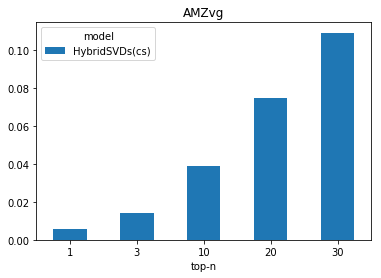

In [48]:
report_results('topn', result_cold, 'coverage');

### saving data

In [49]:
save_results(experiment_name+'_coldstart', cv=result_cold)